<a href="https://colab.research.google.com/github/vladimir22092400/winequality/blob/main/wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. business analysis

### 1.1 Task:

Get a dataset at Kaggle

### 1.2 Target:
Predict the quality of wine

### 1.3 Getting data

In [10]:
! pip install -q kaggle

In [11]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download -d rajyellow46/wine-quality

  0% 0.00/98.0k [00:00<?, ?B/s]
100% 98.0k/98.0k [00:00<00:00, 46.4MB/s]


In [13]:
! unzip wine-quality.zip

Archive:  wine-quality.zip
  inflating: winequalityN.csv        


## 2. data understanding

### 2.1 Importing libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### 2.2 Auxiliary functions

In [55]:
def plot_bar(data, **kwargs):
  '''plot seaborn  barplot'''
  title = kwargs.get('title', '')
  figsize = kwargs.get('figsize', (8, 6))
  rotation = kwargs.get('rotation', 0)

  x_data = data[0]
  y_data = data[1]
  fig = plt.figure(figsize=figsize)
  sns.barplot(x=x_data, y=y_data)
  plt.title(title, fontsize=10)
  up_lim = max(y_data) + 0.1 * max(y_data)
  plt.ylim([0, up_lim])
  plt.xticks(rotation=rotation)
  for j in range(len(y_data)):
    plt.text(j, y_data[j], y_data[j], ha='center', va='bottom', fontsize=8)
  plt.show()


def plot_hist(df, columns, **kwargs):
  '''plot a seaborn histplots of selected dataframe columns'''
  n_rows = kwargs.get('n_rows', 1)
  n_cols = kwargs.get('n_cols', 1)
  figsize = kwargs.get('figsize', (8, 6))
  fig = plt.figure(figsize=figsize)
  for i, col in enumerate(columns):
      ax=fig.add_subplot(n_rows, n_cols, i+1)
      sns.histplot(data=df, x=df[col], bins=30, ax=ax)
      ax.set(ylabel=None)
  fig.tight_layout()
  plt.show()


def plot_box(df, columns, **kwargs):
  '''plot a seaborn boxplots of selected dataframe columns'''
  n_rows = kwargs.get('n_rows', 1)
  n_cols = kwargs.get('n_cols', 1)
  figsize = kwargs.get('figsize', (8, 6))
  fig = plt.figure(figsize=figsize)
  for i, col in enumerate(columns):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=col, data=df, ax=ax)
  plt.tight_layout()
  plt.show()


def plot_pie(df, col, title='', figsize=(8, 6)):
  '''plot a matplotlib pieplot of selected dataframe column'''
  fig = plt.figure(figsize=figsize)
  data = df[col].value_counts()

  p, tx, autotexts = plt.pie(data, labels=data.index, autopct="")
  for i, a in enumerate(autotexts):
      a.set_text("{}".format(data[i]))
  plt.title(title, fontsize=10)
  plt.show()


def high_corr_features(data, lower_bound=0.8):
  '''returns a list of features with high mutual correlation'''
  high_corr_list = set()
  cols = data.columns.tolist()
  for col in cols:
    inds = list(np.where(data[col] > lower_bound)[0])
    if len(inds) > 0:
      for i in range(len(inds)):
        high_corr_list.add(tuple(sorted([col, cols[inds[i]]])))

  high_corr_list = sorted(high_corr_list)
  return high_corr_list
  

def get_bounds(arr):
  '''returns the lower and upper bounds for finding outliers in the array'''
  q1 = np.percentile(arr, 25)
  q3 = np.percentile(arr, 75)
  iqr = q3 - q1

  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  return lower_bound, upper_bound


def get_quality_data(dat):
  '''returns a list of unique values of the dataframe.quality column and the number of rows for each value'''
  data_list = []
  x_data = sorted(dat.quality.unique())
  y_data = dat.groupby('quality')['type'].count().tolist()
  data_list.extend([x_data, y_data])

  return data_list
  

def features_target_correlation(dat):
  '''returns a list of absolute values of the correlation of features with the target variable'''
  data_list = []
  feature_columns = dat.columns[:-1]
  target_corrs = []
  for col in feature_columns:
    target_corrs.append(round(abs(dat['quality'].corr(dat[col])), 3))
  x_data = feature_columns
  y_data = target_corrs
  data_list.extend([x_data, y_data])

  return data_list


def get_ExtraTreesClassifier_importance(X, y):
  '''returns a list of ExtraTreesClassifier features importance'''
  data_list = []
  etc = ExtraTreesClassifier(n_estimators=50, random_state = 42)
  etc.fit(X, y)
  importance = etc.feature_importances_
  importance = np.round(importance, 3)
  x_data = X.columns.tolist()
  y_data = importance
  data_list.extend([x_data, y_data])
  
  return data_list


def classify(model, X, y):
  '''returns metrics and cross_val_score.mean()'''
  rs = 0
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
  if (y_train.nunique() != y_test.nunique()): # not all classes were included in the test sample
    while(y_train.nunique() != y_test.nunique()):
      rs += 1
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  prec = precision_score(y_test, y_pred, average='weighted')
  rec = recall_score(y_test, y_pred, average='weighted')
  score = cross_val_score(model, X, y, cv=5)

  return acc, f1, prec, rec, np.mean(score)

### 2.3 Loading data

In [14]:
df = pd.read_csv('winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


It is unclear why it was necessary to collect a dataset from different types of wine. White and red wines most likely have different characteristics.

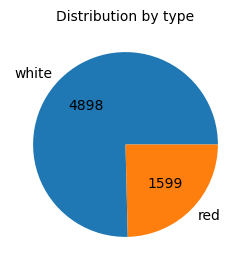

In [15]:
plot_pie(df, 'type', title='Distribution by type', figsize=(4, 3))

In [16]:
feature_columns = df.columns[1:-1]
df.loc[df['type'] == 'red'][feature_columns].describe().compare(df[df['type'] == 'white'][feature_columns].describe()).T.drop(columns=['count'])

mean        std      min         25%  \
fixed acidity        self     8.322104   1.740767  4.60000    7.100000   
                     other    6.855532   0.843808  3.80000    6.300000   
volatile acidity     self     0.527738   0.179085  0.12000    0.390000   
                     other    0.278252   0.100811  0.08000    0.210000   
citric acid          self     0.271145   0.194744      NaN    0.090000   
                     other    0.334250   0.120985      NaN    0.270000   
residual sugar       self     2.538806   1.409928  0.90000    1.900000   
                     other    6.393250   5.072275  0.60000    1.700000   
chlorides            self     0.087467   0.047065  0.01200    0.070000   
                     other    0.045778   0.021850  0.00900    0.036000   
free sulfur dioxide  self    15.874922  10.460157  1.00000    7.000000   
                     other   35.308085  17.007137  2.00000   23.000000   
total sulfur dioxide self    46.467792  32.895324  6.00000   22.000000   
                     other  138.360657  42.498065  9.00000  108.000000   
density              self     0.996747   0.001887  0.99007    0.995600   
                     other    0.994027   0.002991  0.98711    0.991723   
pH                   self     3.310864   0.154290  2.74000    3.210000   
                     other    3.188203   0.151014  2.72000    3.090000   
sulphates            self     0.658078   0.169594  0.33000    0.550000   
                     other    0.489835   0.114147  0.22000    0.410000   
alcohol              self    10.422983   1.065668  8.40000         NaN   
                     other   10.514267   1.230621  8.00000         NaN   

                                  50%         75%        max  
fixed acidity        self     7.90000    9.200000   15.90000  
                     other    6.80000    7.300000   14.20000  
volatile acidity     self     0.52000    0.640000    1.58000  
                     other    0.26000    0.320000    1.10000  
citric acid          self     0.26000    0.420000    1.00000  
                     other    0.32000    0.390000    1.66000  
residual sugar       self     2.20000    2.600000   15.50000  
                     other    5.20000    9.900000   65.80000  
chlorides            self     0.07900    0.090000    0.61100  
                     other    0.04300    0.050000    0.34600  
free sulfur dioxide  self    14.00000   21.000000   72.00000  
                     other   34.00000   46.000000  289.00000  
total sulfur dioxide self    38.00000   62.000000  289.00000  
                     other  134.00000  167.000000  440.00000  
density              self     0.99675    0.997835    1.00369  
                     other    0.99374    0.996100    1.03898  
pH                   self     3.31000    3.400000    4.01000  
                     other    3.18000    3.280000    3.82000  
sulphates            self     0.62000    0.730000    2.00000  
                     other    0.47000    0.550000    1.08000  
alcohol              self    10.20000   11.100000   14.90000  
                     other   10.40000   11.400000   14.20000

The dataset would need to be broken down by type of wine. But that's not the purpose of this assignment, so it won't be done.

### 2.4 Statistics

In [17]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [18]:
df.isnull().sum().loc[df.isnull().sum() > 0]

fixed acidity       10
volatile acidity     8
citric acid          3
residual sugar       2
chlorides            2
pH                   9
sulphates            4
dtype: int64

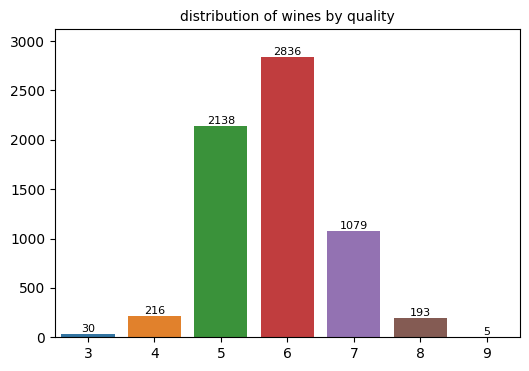

In [19]:
data = get_quality_data(df)
plot_bar(data, title='distribution of wines by quality', figsize=(6, 4), rotation=0)

Classes are not balanced.

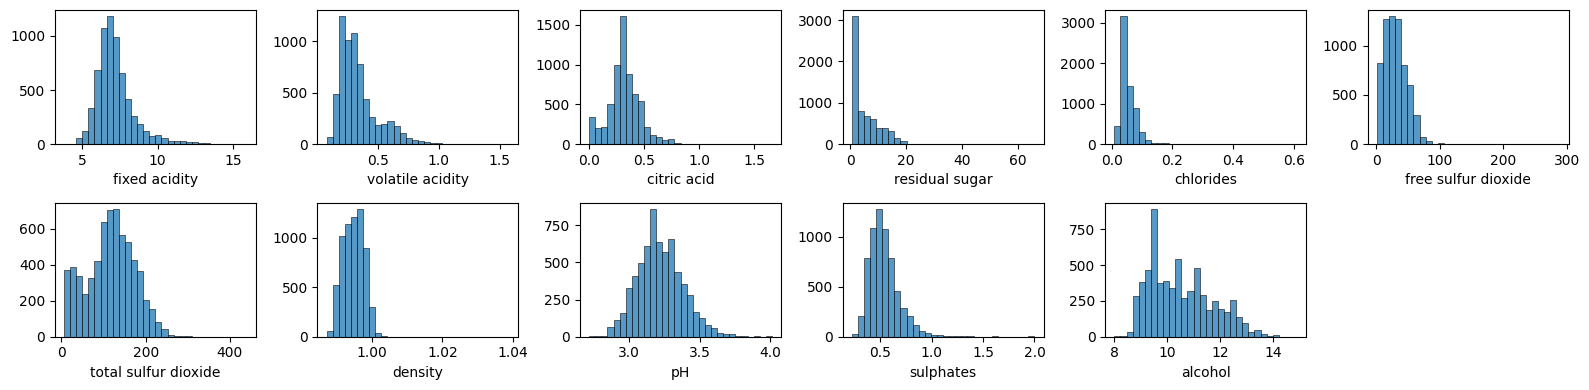

In [20]:
plot_hist(df, feature_columns, n_rows=2, n_cols=6, figsize=(16, 4))

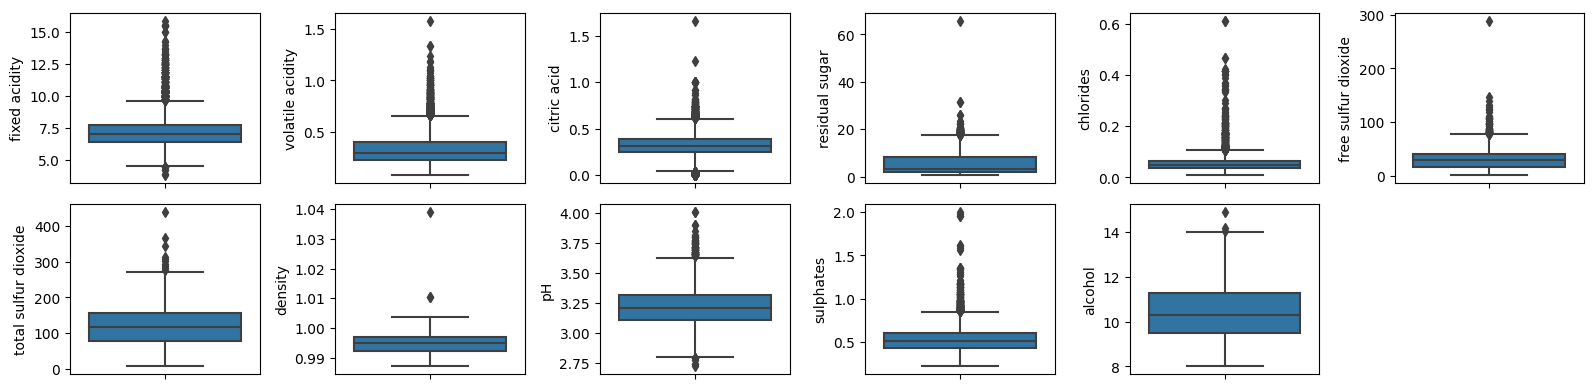

In [21]:
plot_box(df, feature_columns, n_rows=2, n_cols=6, figsize=(16, 4))

A lot of outliers.

In [22]:
df['type'] = np.where(df['type'] == 'white', 0, 1)
feature_columns = df.columns[:-1]

corrs = df[feature_columns].corr().apply(abs)
np.fill_diagonal(corrs.values, 0) # The values on the main diagonal are equal to zero.
corrs.style.background_gradient(cmap='Blues')

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
type,0.000000,0.487241,0.652875,0.187126,0.349000,0.512622,0.471644,0.700357,0.390645,0.328727,0.486916,0.032970
fixed acidity,0.487241,0.000000,0.220172,0.323736,0.112319,0.298421,0.283317,0.329747,0.459204,0.251814,0.300380,0.095603
volatile acidity,0.652875,0.220172,0.000000,0.378061,0.196702,0.377167,0.353230,0.414928,0.271193,0.260660,0.225476,0.038248
citric acid,0.187126,0.323736,0.378061,0.000000,0.142486,0.039315,0.133437,0.195218,0.096320,0.328689,0.057613,0.010433
residual sugar,0.349000,0.112319,0.196702,0.142486,0.000000,0.128902,0.403439,0.495820,0.552498,0.267050,0.185745,0.359706
chlorides,0.512622,0.298421,0.377167,0.039315,0.128902,0.000000,0.195042,0.279580,0.362594,0.044806,0.395332,0.256861
free sulfur dioxide,0.471644,0.283317,0.353230,0.133437,0.403439,0.195042,0.000000,0.720934,0.025717,0.145191,0.188489,0.179838
total sulfur dioxide,0.700357,0.329747,0.414928,0.195218,0.495820,0.279580,0.720934,0.000000,0.032395,0.237687,0.275381,0.265740
density,0.390645,0.459204,0.271193,0.096320,0.552498,0.362594,0.025717,0.032395,0.000000,0.011920,0.259454,0.686745
pH,0.328727,0.251814,0.260660,0.328689,0.267050,0.044806,0.145191,0.237687,0.011920,0.000000,0.191248,0.121002


In [23]:
suspicious_features = high_corr_features(corrs, lower_bound=0.7)
suspicious_features # The list of features with the correlation above lower_bound

[('free sulfur dioxide', 'total sulfur dioxide'),
 ('total sulfur dioxide', 'type')]

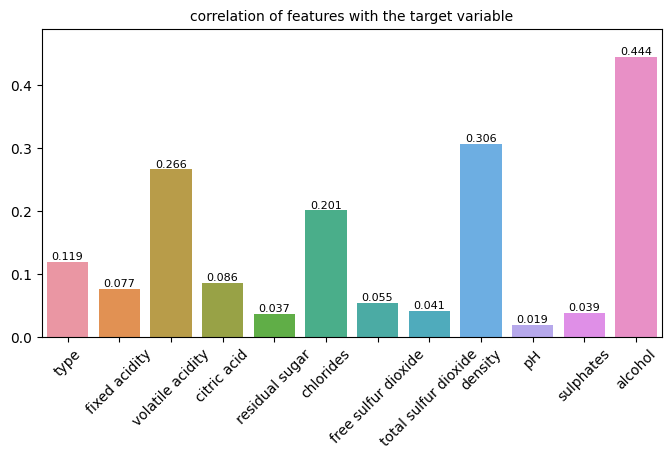

In [24]:
data = features_target_correlation(df)
plot_bar(data, title='correlation of features with the target variable', figsize=(8, 4), rotation=45)

No strong correlation.

## 3. Data Preparation

In [25]:
X = df[feature_columns]
y = df.quality

### 3.1 Fill in missing values in variables.

In [26]:
null_columns = X.isnull().sum().loc[X.isnull().sum() > 0].index.tolist()
for col in null_columns: # The median (outliers) value of the column will be filled in.
  X[col] = X[col].fillna(df.groupby('type')[col].transform(lambda x: x.median()))

### 3.3 Eliminating outliers.

The outliers will be replaced by 05 and 95 quantiles.

In [28]:
for col in feature_columns:
  bounds = get_bounds(df[col]) # Finding outliers.
  q05 = X[col].quantile(0.05)
  q95 = X[col].quantile(0.95)
  X[col][np.where(X[col] <= bounds[0])[0]] = q05
  X[col][np.where(X[col] >= bounds[1])[0]] = q95

### 3.4 Bringing data to a single scale.

In [ ]:
scaler = MinMaxScaler()
columns_to_scale = X.columns[1:]
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

### 3.5. Feature importance.

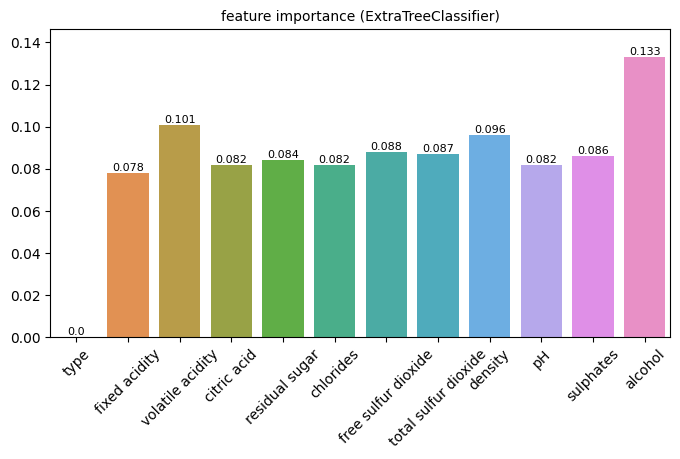

In [29]:
data = get_ExtraTreesClassifier_importance(X, y)
plot_bar(data, title='feature importance (ExtraTreeClassifier)', figsize=(8, 4), rotation=45)

In [ ]:
X.drop(columns=['type'], inplace=True)

### 3.6 Saving intermediate results

In [66]:
pd.concat([X, y]).to_csv('inermediate_results.csv')

### 3.6 Class Imbalancement

In [30]:
classes = sorted(y.unique())
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, class_weights))

oversample = SMOTE(k_neighbors=4, random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)

## 4. Modeling

### 4.1 Model Selection

In [36]:
model1 = RandomForestClassifier(random_state=42, class_weight=class_weights)
model2 = RandomForestClassifier(random_state=42)

### 4.2 Model Training

In [58]:
result1 = np.array(classify(model1, X, y))
result2 = np.array(classify(model2, X_resampled, y_resampled))

## 5. Evaluation

In [62]:
ind = ['model1', 'model2']
cols = ['accuracy', 'f_score', 'precision', 'recall', 'cross_val_score']
result = pd.DataFrame(np.stack((result1, result2), axis=0), index=ind, columns=cols)
result

,accuracy,f_score,precision,recall,cross_val_score
model1,0.691282,0.678221,0.699387,0.691282,0.513927
model2,0.885326,0.882311,0.881363,0.885326,0.828834


## 6. Saving Results

In [63]:
result.to_csv('result.csv')